# Rent analysis

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse, stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals.joblib import Parallel, delayed
from sklearn.pipeline import (FeatureUnion, Pipeline, _fit_transform_one,
                              _transform_one)
from sklearn.preprocessing import FunctionTransformer
from sklearn_pandas import DataFrameMapper

plt.style.use("fivethirtyeight")

warnings.filterwarnings('ignore')

## Loading data

In [2]:
df = pd.read_json("./tunann.jl", encoding="utf-8", lines=True)

## Cleaning

In [3]:
#https://zablo.net/blog/post/pandas-dataframe-in-scikit-learn-feature-union
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y, **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [4]:
# https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(
                "The DataFrame does not include the columns: %s" % cols_error)

In [5]:
class NumFromStringExtractor(BaseEstimator, TransformerMixin):
    """
    Remove non numeric characters from a string and convert it to a number
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        extract_num = lambda x: "".join([i for i in str(x) if i.isdecimal()])
        if isinstance(X, pd.DataFrame):
            return X.applymap(extract_num).apply(pd.to_numeric)
        else:
            return X.apply(extract_num).apply(pd.to_numeric).to_frame()

In [6]:
class ColumnSplitterByChar(BaseEstimator, TransformerMixin):
    """
    Split a string column by a char and save the result in another column
    """

    def __init__(self, split_char, out_cols):
        self.split_char = split_char
        self.out_cols = out_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming operations preserve order
        # TODO: check they do
        # TODO: error check for resulting columns and provided column names (pandas already does it)
        return pd.DataFrame(
            X.astype(str).str.split(self.split_char).tolist(),
            columns=self.out_cols)

**feature ideas**

* weather (coastal or not)
* map information (downloaded from overpass)

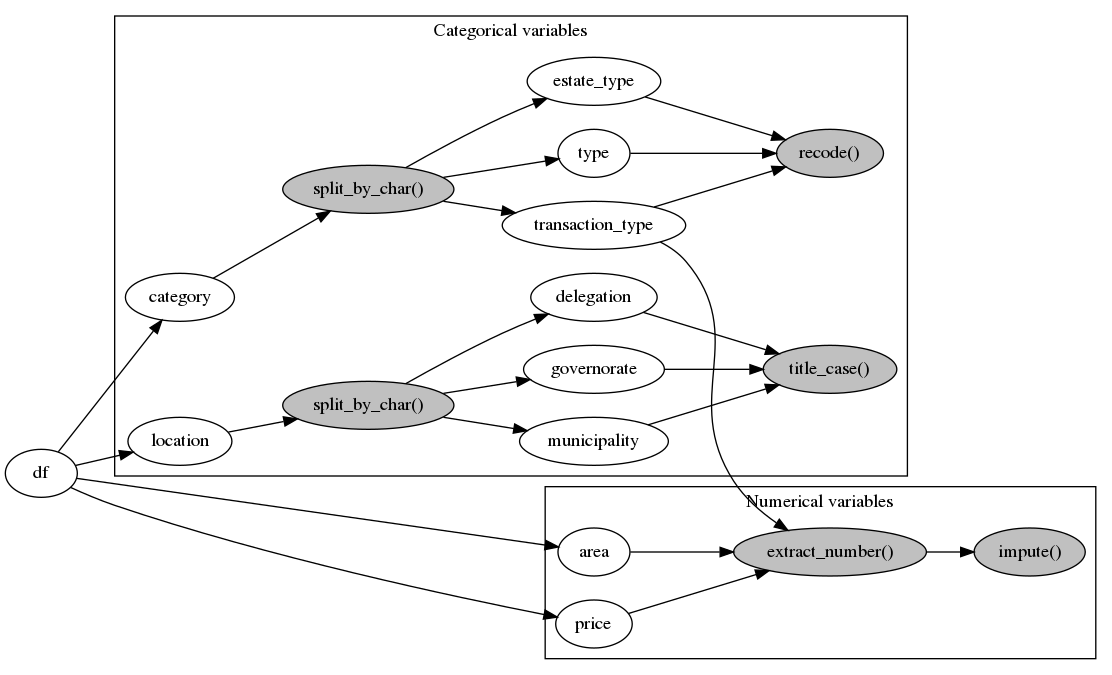

In [73]:
%%dot

digraph {
    rankdir=LR;
    df -> area;
    df -> price;
    df -> category;
    df -> location;
    
    subgraph cluster_0 {
        label="Numerical variables";
        
        extract_number[label="extract_number()",fillcolor="grey",style="filled"];
        impute[label="impute()",fillcolor="grey",style="filled"];
        
        area -> extract_number;
        price -> extract_number;
        extract_number -> impute;
    }
    subgraph cluster_1 {
        label="Categorical variables";
        
        category_split_by_char[label="split_by_char()",fillcolor="grey",style="filled"];
        location_split_by_char[label="split_by_char()",fillcolor="grey",style="filled"];
        recode[label="recode()",fillcolor="grey",style="filled"];
        title_case[label="title_case()",fillcolor="grey",style="filled"];
        
        category -> category_split_by_char;
        location -> location_split_by_char;
        
        category_split_by_char -> type;
        category_split_by_char -> transaction_type;
        category_split_by_char -> estate_type;
        
        location_split_by_char -> governorate;
        location_split_by_char -> delegation;
        location_split_by_char -> municipality;
        
        governorate -> title_case;
        delegation -> title_case;
        municipality -> title_case;
        
        type -> recode;
        transaction_type -> recode;
        estate_type -> recode;
        
        transaction_type -> extract_number;
    }
        
    
}